In [8]:
import torch
from data_process import get_data_loaders, getFeatures
from lstm import Encoder, Decoder, Seq2Seq
from utils import plot_losses, plot_column, plot_output
import pandas as pd
# updated notebook

In [10]:
data = pd.read_csv('flights.csv')
input_seq_len = 10
output_seq_len = 2
test_size = 0.2,
val_size = 0.25,
batch_size = 64,
rand_state = 42
data, train_loader, val_loader, test_loader = get_data_loaders()
features = getFeatures()

[0.0041988  0.00420218 0.00420386 ... 0.41108662 0.41109065 0.41109251]


In [3]:
data.head()

,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,route,max_altitude,min_altitude,mean_altitude,power,time_diff,current_atm,energy_atm,current_consumed,energy_consumed
0,1,0.0,0.005525,0.033426,0.763874,0.008701,0.002053,0.99996,0.715950,0.570210,...,0.4,0.25,0.25,0.25,0.010330,0.000000,0.002039,0.002267,0.003602,0.004199
1,1,0.2,0.005525,0.008357,0.764581,0.008869,0.002053,0.99996,0.715949,0.570205,...,0.4,0.25,0.25,0.25,0.010521,0.037879,0.002185,0.002432,0.003605,0.004202
2,1,0.3,0.005525,0.980501,0.764404,0.008869,0.002053,0.99996,0.715952,0.570205,...,0.4,0.25,0.25,0.25,0.010521,0.018939,0.002112,0.002349,0.003607,0.004204
3,1,0.5,0.005525,0.986072,0.764228,0.008869,0.002053,0.99996,0.715956,0.570213,...,0.4,0.25,0.25,0.25,0.010521,0.037879,0.002185,0.002432,0.003610,0.004207
4,1,0.6,0.005525,1.000000,0.762284,0.008534,0.002053,0.99996,0.715960,0.570213,...,0.4,0.25,0.25,0.25,0.010139,0.018939,0.002100,0.002336,0.003611,0.004209


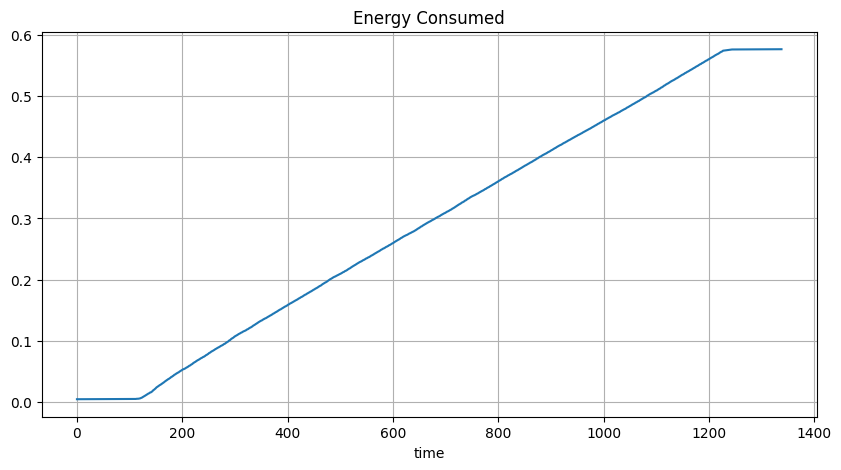

In [4]:
plot_column(data[data["flight"] == 1], "energy_consumed")

In [5]:
# Train model 
# Assuming the model is already defined as per your provided classes
from tqdm import tqdm

input_size = len(features)
hidden_size = 100  
num_layers = 3

encoder = Encoder(input_size, hidden_size, num_layers)
decoder = Decoder(1, hidden_size, num_layers)  # Decoder input size is 1 since we predict one step at a time
seq2seq_model = Seq2Seq(encoder, decoder)
output_seq_length = 2

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq_model.parameters(), lr=0.0001)

# Training loop with validation and early stopping
num_epochs = 1  # Example epochs
best_val_loss = float('inf')
early_stopping_patience = 3  # Number of epochs to wait after last time validation loss improved.
early_stopping_counter = 0  # Counter for early stopping

train_losses, val_losses = [], []

for epoch in range(num_epochs):

    # Training phase
    seq2seq_model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        optimizer.zero_grad()
        outputs = seq2seq_model(inputs)  # No need for target length
        # Adjust the dimensions if necessary, based on your loss function requirements
        # Example: If your outputs and targets are both [batch_size, 2, 1]
        outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
        targets = targets[:, :output_seq_length]  # Ensuring targets are of the correct length

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})
   
    
    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.4f}")

    # Validation phase
    seq2seq_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
        for inputs, targets in progress_bar:
            outputs = seq2seq_model(inputs)  # No need for target length
            # Adjust dimensions as in the training phase
            outputs = outputs.squeeze(-1)
            targets = targets[:, :output_seq_length]

            loss = criterion(outputs, targets)

            total_val_loss += loss.item()
            progress_bar.set_postfix({'val_loss': loss.item()})

    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.4f}")

    # Check for early stopping
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        torch.save(seq2seq_model.state_dict(), 'best_model.pth')
        print("Saved the new best model.")
        early_stopping_counter = 0  # reset counter if validation loss improves
    else:
        early_stopping_counter += 1
        print(f"Validation loss did not improve. Counter {early_stopping_counter}/{early_stopping_patience}")
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break  # Stop training


Epoch 1/1 [TRAIN]: 100%|██████████| 2418/2418 [00:37<00:00, 63.66it/s, train_loss=0.00397] 


Epoch 1/1, Average Training Loss: 0.0036


Epoch 1/1 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 138.95it/s, val_loss=0.000473]

Epoch 1/1, Average Validation Loss: 0.0009
Saved the new best model.


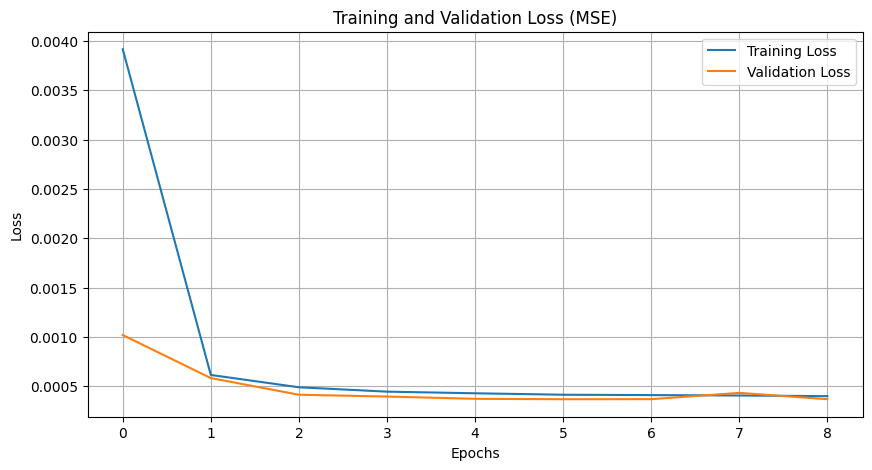

In [7]:
plot_losses(train_losses=train_losses, val_losses=val_losses)

In [6]:
# Load the best model
seq2seq_model.load_state_dict(torch.load('best_model.pth'))

# Test the model
seq2seq_model.eval()
with torch.no_grad():
    total_loss = 0
    for inputs, targets in test_loader:
        outputs = seq2seq_model(inputs)  # No need for target length
        # Adjust the dimensions if necessary, based on your loss function requirements
        # Example: If your outputs and targets are both [batch_size, 2, 1]
        outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
        targets = targets[:, :output_seq_length]  # Ensuring targets are of the correct length

        loss = criterion(outputs, targets)
        total_loss += loss.item()  
    print(f"Average test loss: {total_loss / len(test_loader)}")

Average test loss: 0.0010412845119071902


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


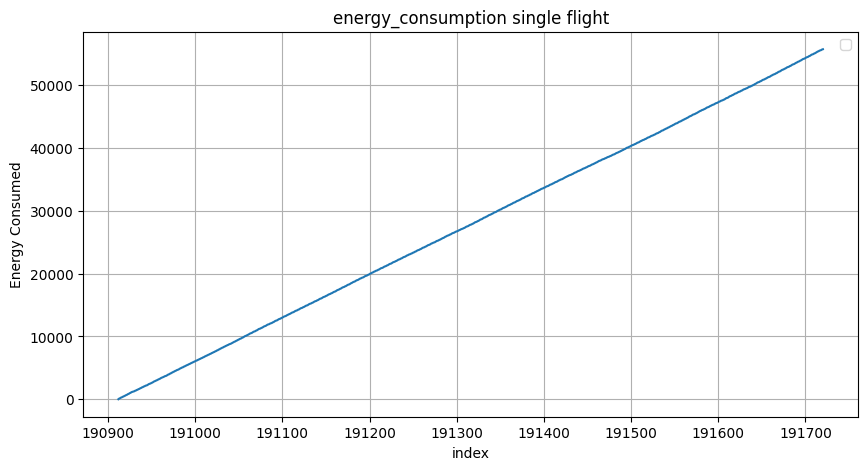

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


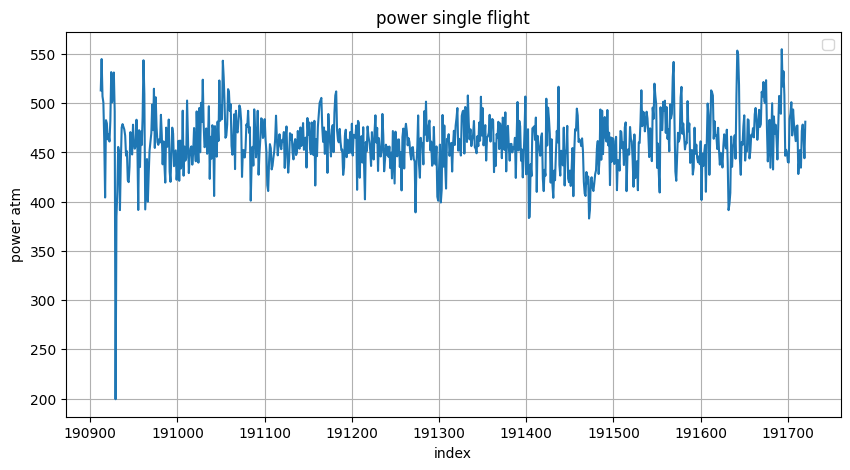

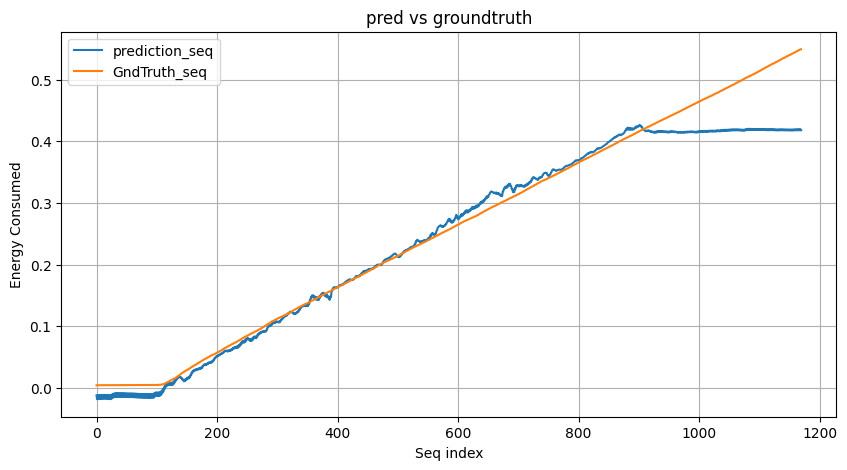

Average test loss: 1.69827104788782e-06


In [32]:
from data_process import create_sequences, calculate_consumptions
from utils import plot_output
import torch
import matplotlib.pyplot as plt
# Load the best model
seq2seq_model.load_state_dict(torch.load('best_model.pth'))

# Test the model
seq2seq_model.eval()
# input_seq, output_seq = create_sequences(data[data['flight'] == 2][features].values, data[data['flight'] == 2]['energy_consumed'].values,10,2)
#####
data = pd.read_csv('flights.csv')
data = calculate_consumptions(data)
flight = 221
flight_energy= data[data['flight'] == flight]['energy_consumed']
data['power'] = data['battery_current'] * data['battery_voltage']
flight_power = data[data['flight'] == flight]['power']
# print(flight_energy)
plt.figure(figsize=(10, 5))
plt.plot(flight_energy)
plt.title('energy_consumption single flight')
plt.xlabel('index')
plt.ylabel('Energy Consumed')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(flight_power)
plt.title('power single flight')
plt.xlabel('index')
plt.ylabel('power atm')
plt.legend()
plt.grid(True)
plt.show()
#######
input_seq = torch.tensor(input_seq, dtype=torch.float32)
output_seq = torch.tensor(output_seq, dtype=torch.float32)

with torch.no_grad():
    total_loss = 0
    output_arr = []
    target_arr = []
    
    outputs = seq2seq_model(input_seq)  # No need for target length
    # Adjust the dimensions if necessary, based on your loss function requirements
    # Example: If your outputs and targets are both [batch_size, 2, 1]
    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    
    plot_output(outputs,targets,2)
    # break
    ###########
    loss = criterion(outputs, targets)
    total_loss += loss.item()
    print(f"Average test loss: {total_loss / len(test_loader)}")

    